# ClimAgent quick start

In [39]:
from climagent.agent.climagent import ClimAgent
from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI
import os
from dotenv import load_dotenv
import xarray as xr

load_dotenv("../credentials.env")
import earthkit.data as ekd

import warnings 
warnings.filterwarnings("ignore")

In [40]:
# Initialize LLM
llm = AzureChatOpenAI(
    deployment_name=os.getenv("GPT_DEPLOYMENT_NAME"),
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_ENDPOINT"),
    temperature=0,
)

In [41]:
ds = ekd.from_source("cds",
        "reanalysis-era5-single-levels-timeseries",
        variable=["2m_temperature", "total_precipitation"],
        location= {"longitude": 7, "latitude": 45},
        date =  ["1940-01-01","2024-12-31"],
        data_format = "netcdf"
        )

2025-04-08 14:45:26,183 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-08 14:45:26,183 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-08 14:45:26,245 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-08 14:45:26,245 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-08 14:45:26,512 WARNING [2025-03-17T00:00:00] Please be aware that the generation of this dataset 

In [42]:
dataset = ds.to_xarray().rename({"valid_time": "time"})
dataset

<xarray.Dataset> Size: 12MB
Dimensions:    (time: 745128)
Coordinates:
    latitude   float64 8B ...
    longitude  float64 8B ...
  * time       (time) datetime64[ns] 6MB 1940-01-01 ... 2024-12-31T23:00:00
Data variables:
    t2m        (time) float32 3MB dask.array<chunksize=(745128,), meta=np.ndarray>
    tp         (time) float32 3MB dask.array<chunksize=(745128,), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-09-02T04:48 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [43]:
agent = ClimAgent(dataset, llm)
# agent.graph

In [44]:
query: str = (
    "Select the temperature and resample the data yearly. **Don't aggregate on time!!**\n"
    "Can you see any trend in the data?"
)

messages = [HumanMessage(query)]
response = agent.run(messages)

In [45]:
print(response['messages'][-1].content)

The temperature data has been successfully selected and resampled yearly. Here are the details:

- **Temperature Variable**: The variable selected is 't2m', which represents the 2-meter temperature.
- **Resampling**: The data has been resampled on a yearly basis, resulting in a dataset that contains temperature values for each year from 1940 to 2024.

### Observing Trends
To analyze trends in the resampled temperature data, we can look at the yearly temperature values. A common method to identify trends is to perform a linear regression analysis or visualize the data in a time series plot.

Would you like me to perform a specific analysis or visualization to identify trends in the temperature data?


In [46]:
agent.dataset_state.history

["Selected variables:['t2m'])", 'Group on time(1Y)']

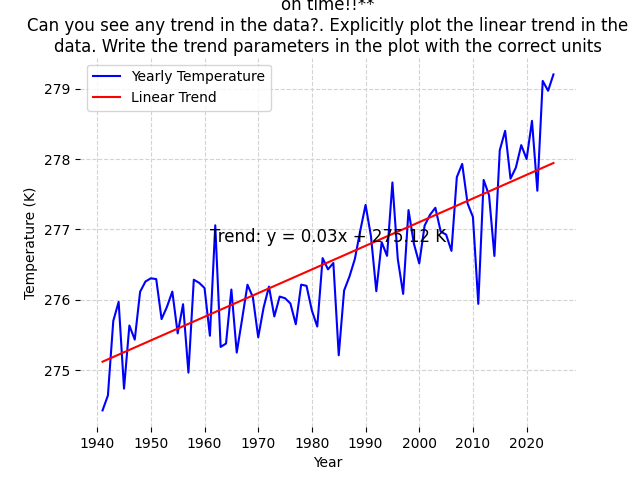

In [50]:
from lida import Manager, TextGenerationConfig , llm 

text_gen = llm(
    provider="openai",
    api_type="azure",
    azure_endpoint=os.getenv("AZURE_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("OPENAI_API_VERSION"),
)

lida = Manager(text_gen=text_gen)
textgen_config = TextGenerationConfig(n=1, temperature=0.0, model=os.getenv("GPT_DEPLOYMENT_NAME"), use_cache=False)

df = agent.dataset_state.dataset.to_dataframe().drop(columns=["latitude", "longitude"])

# **** lida.summarize *****
summary = lida.summarize(
    df,
    summary_method='llm',
    textgen_config=textgen_config)

visualizations = lida.visualize(
                    summary=summary,
                    goal=f"{query}. Explicitly plot the linear trend in the data. Write the trend parameters in the plot with the correct units",
                    textgen_config=textgen_config,
                    library='matplotlib')

display(visualizations[0])